In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf 
from tensorflow import keras
from keras.layers import Flatten

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import os
import tempfile

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cartopy.crs as ccrs
from datetime import datetime

In [2]:
df = pd.read_csv("/Users/robbiefeldstein/Documents/Programming/Research/Datasets/nolines.csv")
df.head()


,Unnamed: 0,Coordinates,nearest_time,lightning,CMI_C01,CMI_C02,CMI_C03,CMI_C04,CMI_C05,CMI_C06,...,CMI_C15,CMI_C16,ACM,BCM,Cloud_Probabilities,lat,lon,time,time_int,Lightning
0,0,"(40.13103323474366, -93.38155072424266)",0,0.0,0.441091,0.384742,0.525476,0.024544,0.413254,0.336766,...,264.25080,254.35742,3.0,1.0,0.999627,40.131033,-93.381551,2022-05-21 17:00:31.270424960,1653152431270424960,0
1,1,"(40.12698592712501, -93.2741436595977)",0,0.0,0.456726,0.401210,0.551626,0.032917,0.422262,0.352678,...,260.96378,251.56548,3.0,1.0,0.999482,40.126986,-93.274144,2022-05-21 17:00:31.270424960,1653152431270424960,0
2,2,"(40.122965705716815, -93.16685328500078)",0,0.0,0.439722,0.378769,0.518789,0.068512,0.373928,0.331329,...,249.12234,241.57506,3.0,1.0,0.999352,40.122966,-93.166853,2022-05-21 17:00:31.270424960,1653152431270424960,0
3,3,"(40.11897247748837, -93.05967862352706)",0,0.0,0.423154,0.358869,0.497658,0.092738,0.330793,0.307440,...,241.76660,235.51263,3.0,1.0,0.999352,40.118972,-93.059679,2022-05-21 17:00:31.270424960,1653152431270424960,0
4,4,"(40.115006150366405, -92.95261870531907)",0,0.0,0.445238,0.380516,0.509682,0.130238,0.319762,0.311349,...,232.43045,228.00778,3.0,1.0,0.999366,40.115006,-92.952619,2022-05-21 17:00:31.270424960,1653152431270424960,0


In [3]:
#Look at class imbalance

neg, pos = np.bincount(df['Lightning'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 937500
    Positive: 10114 (1.08% of total)



In [4]:
features = ["CMI_C01","CMI_C02","CMI_C03","CMI_C04","CMI_C05","CMI_C06","CMI_C07","CMI_C08","CMI_C09","CMI_C10","CMI_C11","CMI_C12","CMI_C13","CMI_C14","CMI_C15", "CMI_C16" ,"ACM","BCM","Cloud_Probabilities","Lightning"]

copy_df = df.copy()
copy_df = copy_df[features]

X = copy_df[features]

# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(copy_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Lightning'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Lightning'))
test_labels = np.array(test_df.pop('Lightning'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)
features = ["CMI_C01","CMI_C02","CMI_C03","CMI_C04","CMI_C05","CMI_C06","CMI_C07","CMI_C08","CMI_C09","CMI_C10","CMI_C11","CMI_C12","CMI_C13","CMI_C14","CMI_C15", "CMI_C16" ,"ACM","BCM","Cloud_Probabilities"]
X = copy_df[features]

In [5]:
#Averages are roughly similar

print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0109
Average class probability in validation set: 0.0106
Average class probability in test set:       0.0105


In [6]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (600000,)
Validation labels shape: (150000,)
Test labels shape: (187500,)
Training features shape: (600000, 19)
Validation features shape: (150000, 19)
Test features shape: (187500, 19)


In [7]:
#Recommended parameters for imbalanced model

METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None,dropout_rate=0.25,activation='sigmoid'):

  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential([
    keras.layers.Dense(len(features), activation='relu', input_shape=(train_features.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='sigmoid'),
    keras.layers.Dropout(dropout_rate),
    keras.layers.BatchNormalization(),
    #Output layer
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
])

  model.compile(
      optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)

  return model

2023-12-04 13:53:07.933582: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-04 13:53:07.933602: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-04 13:53:07.933609: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-04 13:53:07.933667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-04 13:53:07.933918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
EPOCHS = 2**7
BATCH_SIZE = 2**16

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=25,
    mode='max',
    restore_best_weights=True)

In [9]:
initial_bias = np.log([pos/len(df)])
print(initial_bias)
model = make_model(output_bias=initial_bias)
model.summary()

[-4.52929616]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 19)                380       
                                                                 
 batch_normalization (Batch  (None, 19)                76        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                1280      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 1)    

In [10]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [11]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

model = make_model(output_bias=initial_bias)
model.predict(train_features[:10],verbose=0)

2023-12-04 13:53:08.367499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loss: 0.0609


2023-12-04 13:53:10.360965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[0.00660096],
       [0.00680107],
       [0.00670511],
       [0.00517172],
       [0.00664175],
       [0.00670203],
       [0.00632385],
       [0.00672102],
       [0.00655726],
       [0.00512018]], dtype=float32)

In [12]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

3/3 [==============================] - 0s 106ms/step


In [13]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 46.35


In [14]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight,
    verbose=1)

Epoch 1/128


2023-12-04 13:53:11.224039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 2.0282 - cross entropy: 0.0658 - Brier score: 0.0117 - tp: 4.0000 - fp: 231.0000 - tn: 1186637.0000 - fn: 13128.0000 - accuracy: 0.9889 - precision: 0.0170 - recall: 3.0460e-04 - auc: 0.5643  

2023-12-04 13:53:12.547910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 2s 144ms/step - loss: 2.0282 - cross entropy: 0.0658 - Brier score: 0.0117 - tp: 4.0000 - fp: 231.0000 - tn: 1186637.0000 - fn: 13128.0000 - accuracy: 0.9889 - precision: 0.0170 - recall: 3.0460e-04 - auc: 0.5643 - val_loss: 0.0545 - val_cross entropy: 0.0545 - val_Brier score: 0.0104 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 148414.0000 - val_fn: 1586.0000 - val_accuracy: 0.9894 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8365
Epoch 2/128
10/10 [==============================] - 1s 65ms/step - loss: 1.2189 - cross entropy: 0.0840 - Brier score: 0.0195 - tp: 420.0000 - fp: 5928.0000 - tn: 587506.0000 - fn: 6146.0000 - accuracy: 0.9799 - precision: 0.0662 - recall: 0.0640 - auc: 0.8166 - val_loss: 0.0504 - val_cross entropy: 0.0504 - val_Brier score: 0.0102 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 148414.0000 - val_fn: 1586.0000 - val_accuracy: 0.9894 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 

In [15]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=1)

3/3 [==============================] - 0s 11ms/step


2023-12-04 13:54:24.065285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 76ms/step - loss: 0.3660 - cross entropy: 0.3660 - Brier score: 0.1257 - tp: 1837.0000 - fp: 35029.0000 - tn: 150509.0000 - fn: 125.0000 - accuracy: 0.8125 - precision: 0.0498 - recall: 0.9363 - auc: 0.9404


In [16]:
test_predictions_weighted

array([[4.3594750e-04],
       [3.3726546e-03],
       [1.5974186e-01],
       ...,
       [5.2367557e-02],
       [5.7319082e-02],
       [5.8253080e-01]], dtype=float32)

In [17]:
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)

print(classification_report(test_labels, test_predictions_weighted.round()))
print(confusion_matrix(test_labels, test_predictions_weighted.round()))

loss :  0.365998238325119
cross entropy :  0.365998238325119
Brier score :  0.1257016509771347
tp :  1837.0
fp :  35029.0
tn :  150509.0
fn :  125.0
accuracy :  0.8125119805335999
precision :  0.049829110503196716
recall :  0.9362894892692566
auc :  0.9404498934745789
              precision    recall  f1-score   support

           0       1.00      0.81      0.90    185538
           1       0.05      0.94      0.09      1962

    accuracy                           0.81    187500
   macro avg       0.52      0.87      0.50    187500
weighted avg       0.99      0.81      0.89    187500

[[150509  35029]
 [   125   1837]]


15/15 [==============================] - 0s 7ms/step


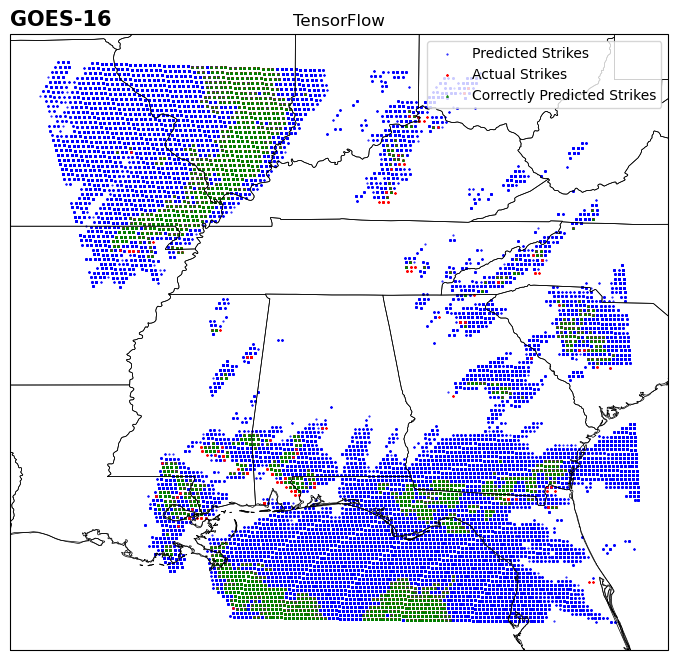

In [29]:

def make_map(name,df):

    copydf = df.copy()
    X = copydf[["CMI_C01","CMI_C02","CMI_C03","CMI_C04","CMI_C05","CMI_C06","CMI_C07","CMI_C08","CMI_C09","CMI_C10","CMI_C11","CMI_C12","CMI_C13","CMI_C14","CMI_C15", "CMI_C16" ,"ACM","BCM","Cloud_Probabilities"]]
    copydf["Predicted"] = weighted_model.predict(X, batch_size=BATCH_SIZE)
    #Set the threshold to 0.25
    copydf["Predicted"] = copydf["Predicted"] > 0.15
    #copydf["Predicted"] = copydf["Predicted"].astype(int)
    copydf["The Same"] = copydf["Predicted"] == copydf["Lightning"]
    copydf["The Same"] = copydf["The Same"].astype(int)
    predicted_lats = copydf[copydf["Predicted"]==1]["lat"]
    predicted_lons = copydf[copydf["Predicted"]==1]["lon"]

    actual_lats = copydf[copydf["Lightning"]==1]["lat"]
    actual_lons = copydf[copydf["Lightning"]==1]["lon"]

    #Lats where the prediction was 1 and the actual was 1
    correct_lats = copydf[(copydf["Predicted"]==1) & (copydf["Lightning"]==1)]['lat']
    correct_lons = copydf[(copydf["Predicted"]==1) & (copydf["Lightning"]==1)]['lon']
    
        
    lc = ccrs.LambertConformal(central_longitude=-97.5,
                                standard_parallels=(38.5, 38.5))

    fig = plt.figure(figsize=(10, 8))

    ax = plt.axes(projection=ccrs.PlateCarree())
    #ax.set_extent([-87, -70, 32, 50], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
    ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)

    #Plot the GLM Data
    ax.scatter(predicted_lons[:], predicted_lats[:],  marker = ".",color = 'blue',s=1)
    ax.scatter(actual_lons[:], actual_lats[:],  marker = "*",color = 'red',s=1)
    ax.scatter(correct_lons[:], correct_lats[:],  marker = "^",color = 'green',s=1)

    #Add legend
    ax.legend(['Predicted Strikes', 'Actual Strikes', 'Correctly Predicted Strikes'])
    plt.title('GOES-16', fontweight='bold', fontsize=15, loc='left')
    plt.title(name)
    
    plt.show()
    

make_map("TensorFlow",df)
